In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import json

from torchvision.transforms import v2

from dataset import FacialKeypointsDataset
from models.model import get_model
from utils import load_model

In [3]:
run_name = "2023-11-23_13-12-53"

run_path = f"runs/{run_name}/"

train_summary = json.load(open(run_path + "train_summary.json"))

MODEL = train_summary["config"]["MODEL"]
IMAGE_SIZE = train_summary["config"]["IMAGE_SIZE"]

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
model = get_model(MODEL)
model = load_model(model, run_path + "best_model.pth")
model.to(DEVICE);

In [5]:
transforms_test = v2.Compose([
    v2.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]),
    v2.ToImage(),
    v2.ToDtype(torch.float),
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE), antialias=True),
])


transforms_train = v2.Compose([
    v2.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]),
    v2.ToImage(),
    v2.ToDtype(torch.float),
    v2.ElasticTransform(alpha=60),
    v2.RandomRotation(degrees=(-70, 70)),
    v2.RandomAffine(degrees=(-15, 15), translate=(0.25, 0.25), scale=(0.7, 1.3), shear=(-15, 15, -15, 15)),
    v2.RandomPerspective(distortion_scale=0.2, p=0.2),
    v2.RandomResizedCrop((IMAGE_SIZE, IMAGE_SIZE), scale=(0.7, 1.4), antialias=True),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    v2.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    v2.RandomAutocontrast(p=0.2),
    v2.RandomEqualize(p=0.2),

    v2.RandomErasing(p=0.4, scale=(0.05, 0.2), ratio=(0.33, 3.3), value=0, inplace=False),
])

test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv', root_dir='data/test/', 
                                    transform=transforms_test)

train_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv', root_dir='data/training/',
                                    transform=transforms_train)

print(len(test_dataset))
print(len(train_dataset))


770
3462


torch.Size([3, 224, 224]) torch.Size([136])


(-0.5, 447.5, 447.5, -0.5)

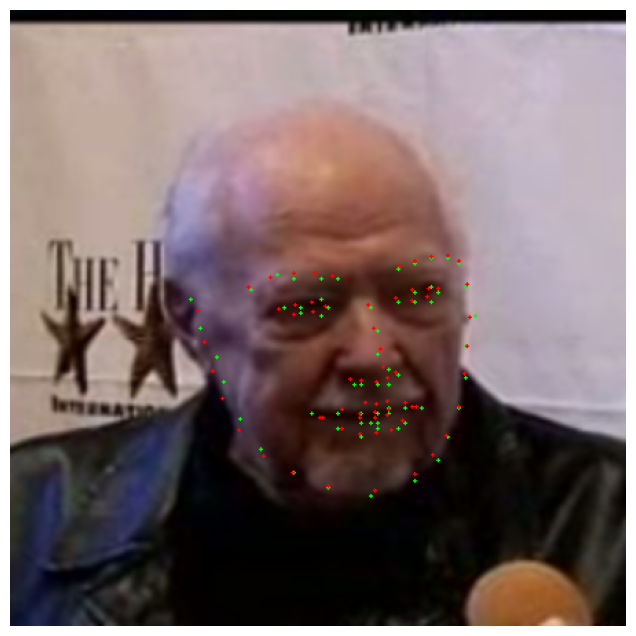

In [23]:
dataset = test_dataset

index = np.random.randint(0, len(dataset))
# index = 5

image, keypoints = dataset[index]
print(image.shape, keypoints.shape)
keypoints = keypoints.reshape(-1, 2)

with torch.no_grad():
    model.eval()
    output = model(image.unsqueeze(0).to(DEVICE))
    output = output.cpu().numpy()
    output = output.reshape(-1, 2)


image = image.permute(1, 2, 0).numpy()
image = image.copy()

image = cv2.resize(image, (image.shape[1]*2, image.shape[0]*2))


for i in range(keypoints.shape[0]):

    keypoints_x = int(keypoints[i, 0] * image.shape[0])
    keypoints_y = int(keypoints[i, 1] * image.shape[1])

    cv2.circle(image, (keypoints_x, keypoints_y), 1, (0, 1, 0), -1)
    
    # cv2.putText(imagesketch, str(i), (keypoints_x, keypoints_y), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 1, 0), 1)

    pred_x = int(output[i, 0] * image.shape[0])
    pred_y = int(output[i, 1] * image.shape[1])

    cv2.circle(image, (pred_x, pred_y), 1, (1, 0, 0), -1)

plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis('off')

In [121]:
print(image.max(), image.min())

1.0000001 0.0
